<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/MobileNet_V2_Training_%5BFreeze_All_Layers%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v2 as tf
import keras
from keras.models import Sequential
from keras.applications import mobilenet_v2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [5]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(1204, 224, 224, 3)
(304, 224, 224, 3)
(1204, 1)
(304, 1)


In [6]:
original_model = keras.applications.mobilenet_v2.MobileNetV2()

14548992/14536120 [==============================] - 0s 0us/step


In [7]:
# Original MobileNetV2 architecture
original_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [8]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D

 https://blog.roboflow.com/how-to-train-mobilenetv2-on-a-custom-dataset/

https://github.com/w5688414/Keras-MobileNetV2-Image-classification/blob/master/mobilenet_v2.py

In [9]:
# Create base model from pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

# Freezing the convolutional base
# Prevents weights in a given layer from being updated during training 
base_model.trainable = False

#for layer in base_model.layers:
#  print(layer, layer.trainable)

# Base model architecture
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [10]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [11]:
#tf.keras.utils.plot_model(base_model, show_shapes = True, show_layer_names = True)

In [12]:
# Create base model from pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

# Freezing the convolutional base
# Prevents weights in a given layer from being updated during training 
base_model.trainable = False

## Adding additional layers

# Applies average pooling on spatial dimensions
# shape (None, 1280)
x = GlobalAveragePooling2D()(base_model.output) 

# Reshape (None, 1280) to (1, 1, 1280)
x = Reshape((1, 1, 1280))(x)

# Apply a Dropout
# Randomly selected neurons are ignored during training; helps prevent overfitting
# Dropout doesn't have any variables/weights that can be frozen during training
x = Dropout(0.3, name='Dropout')(x) 

# 2D convolutional layer
# Shape (1,1,5)
x = Conv2D(5, (1, 1), padding='same', data_format = 'channels_last')(x)

# Feeds all outputs from previous layers to all neurons
x = Activation('softmax', name='softmax')(x)  

# Reshape (1,1,5) to (,5)
x = Reshape((5,))(x)

model = Model(inputs = base_model.inputs, outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

#### The ~2M parameters in MobileNetV2 are frozen, but there are 6.4k trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [13]:
len(model.trainable_variables)

2

In [14]:
model.output_shape

(None, 5)

https://www.tensorflow.org/api_docs/python/tf/keras/losses

In [15]:
# Configuring the model
# Use crossentropy loss function when there are two or more label classes
# Labels are provided as integers -> Use sparse_categorical_crossentropy
# Adjust learning rate to reduce loss
#model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Underfitting: Validation Accuracy higher than Training Accuracy

### Overfitting: Validation Loss much higher than Training Loss

In [16]:
print(train_data.shape[0])
print(test_data.shape[0])

1204
304


In [17]:
#train_steps = train_data.shape[0] // 32
#test_steps = test_data.shape[0] // 32

#print(train_steps)
#print(test_steps)

In [18]:
# Train the model
#training = model.fit(train_data, train_label, steps_per_epoch=train_steps, epochs=20, validation_data=(test_data, test_label), validation_steps=test_steps, verbose=1)
training = model.fit(train_data, train_label, epochs=30, validation_data=(test_data, test_label), verbose=1)

Epoch 1/30
38/38 [==============================] - 45s 1s/step - loss: 1.3486 - accuracy: 0.4743 - val_loss: 0.7713 - val_accuracy: 0.7566
Epoch 2/30
38/38 [==============================] - 40s 1s/step - loss: 0.6855 - accuracy: 0.7741 - val_loss: 0.5594 - val_accuracy: 0.7961
Epoch 3/30
38/38 [==============================] - 40s 1s/step - loss: 0.5184 - accuracy: 0.8289 - val_loss: 0.4741 - val_accuracy: 0.8355
Epoch 4/30
38/38 [==============================] - 41s 1s/step - loss: 0.4164 - accuracy: 0.8596 - val_loss: 0.4032 - val_accuracy: 0.8454
Epoch 5/30
38/38 [==============================] - 40s 1s/step - loss: 0.3671 - accuracy: 0.8912 - val_loss: 0.3630 - val_accuracy: 0.8717
Epoch 6/30
38/38 [==============================] - 40s 1s/step - loss: 0.3271 - accuracy: 0.8962 - val_loss: 0.3324 - val_accuracy: 0.8914
Epoch 7/30
38/38 [==============================] - 40s 1s/step - loss: 0.2860 - accuracy: 0.9194 - val_loss: 0.3087 - val_accuracy: 0.9013
Epoch 8/30
38/38 [==

### Evaluate Performance of Classifier
https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234


https://www.baeldung.com/cs/learning-curve-ml 

In [19]:
test_loss, test_acc = model.evaluate(test_data, test_label)

print("Tested Acc:", test_acc)

10/10 [==============================] - 8s 826ms/step - loss: 0.1756 - accuracy: 0.9375
Tested Acc: 0.9375


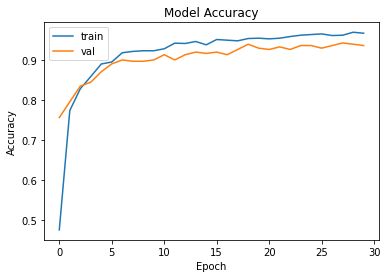

In [20]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

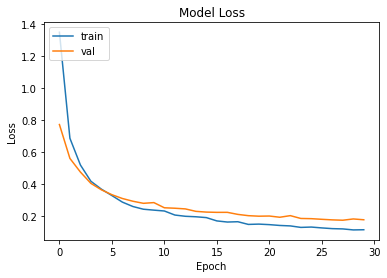

In [21]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
test_label_predict = model.predict(test_data)

In [23]:
print(test_label_predict[0], np.argmax(test_label_predict[0]))

[0.8295285  0.05016364 0.00310454 0.1102206  0.00698267] 0


In [24]:
test_label_pred_array = []

count = 0
for item in test_label_predict:
  test_label_pred_array.append(np.argmax(test_label_predict[count]))
  count+=1

print(count)
#test_label_pred_array

304


In [25]:
print(test_label.shape)

(304, 1)


In [26]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_label, test_label_pred_array)
print('Confusion Matrix\n')
confusion

Confusion Matrix



array([[63,  2,  0,  0,  0],
       [ 1, 66,  0,  2,  0],
       [ 0,  0, 46,  1,  0],
       [ 1,  3,  1, 63,  1],
       [ 0,  0,  1,  6, 47]])

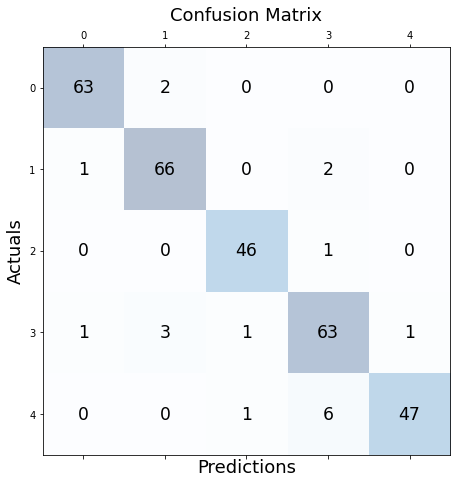

In [27]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [28]:
# Precision = P/(TP+FP)
# Recall = TP/(TP+FN)
# F1 Score = (2 x precision x recall)/(precision + recall)
# Support: number of occurences of the class in the dataset
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_label, test_label_pred_array, target_names=['Ambience', 'Footsteps', 'Horn', 'Music', 'Shout']))


Classification Report

              precision    recall  f1-score   support

    Ambience       0.97      0.97      0.97        65
   Footsteps       0.93      0.96      0.94        69
        Horn       0.96      0.98      0.97        47
       Music       0.88      0.91      0.89        69
       Shout       0.98      0.87      0.92        54

    accuracy                           0.94       304
   macro avg       0.94      0.94      0.94       304
weighted avg       0.94      0.94      0.94       304

